In [63]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from typing import Optional

### 1. Transformacje wejściowych danych

Średnia i odchylenie standardowe zostały obliczone dla każdego kanału korzystająć ze wszystkich zdjęć ze zbioru treningowego.
Normalizacja jest wykonywana zarówno na zbiorze testowym jak i treningowym.

In [64]:
def load_dataset(train: bool, transform: Optional[v2.Compose] = None , download=False) -> Dataset:
    return torchvision.datasets.CIFAR10(root='./data', train=train, download=download, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2470, 0.2435, 0.2616])

basic_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std),
])

train_dataset = load_dataset(train=True, transform=basic_transform)
test_dataset = load_dataset(train=False, transform=basic_transform)

### 2. Augmentacja danych

Dodatkowo na zbiorze treningowym używam augmentacji.

In [65]:
class AugmentedDataset(Dataset):

    def __init__(self, base_dataset: Dataset, augmenting_transforms: v2.Compose) -> None:
        super().__init__()
        
        self.base_dataset = base_dataset
        self.transforms = augmenting_transforms

    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):        
        return self.transforms(self.base_dataset[idx])

augment_transforms = v2.Compose([
    v2.RandomHorizontalFlip(0.5),
    v2.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1), interpolation=v2.InterpolationMode.BILINEAR),
])

augmented_dataset = AugmentedDataset(train_dataset, augment_transforms)

In [66]:
import matplotlib.pyplot as plt


def unnormalize_batch(batch: torch.Tensor):
    unnormalized = batch.permute(0, 2, 3, 1)*std + mean
    return unnormalized.permute(0, 3, 1, 2)
    

def visualize_patches(sequence_of_patches: torch.Tensor, patch_size: int, nrow: int) -> None:
    sequence_length  = len(sequence_of_patches)
    sequence_of_images = sequence_of_patches.reshape(sequence_length, 3,patch_size, patch_size)
    
    sequence_of_images = unnormalize_batch(sequence_of_images)
    image_grid = torchvision.utils.make_grid(sequence_of_images, nrow=nrow, padding=1, pad_value=1)
    
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

### 3. Podział obrazu na patche

Do podziału obrazu używam operacji unfold, która wycina z obrazu kolejne kwadraty (razem ze wszystkimi kanałami), a następnie wszystkie wartości z jednego wycinka układane są w jedną kolumnę tensora. Jeśli stride będzie miał wartość taką samą jak bok wycinane kwadratu to patche będą rozłączne.

In [67]:
import torch.nn as nn


class Patch(nn.Module):

    def __init__(self, patch_size: int, image_size: int, in_channels: int = 3):
        super().__init__()

        if image_size % patch_size:
            raise AssertionError("Image size should be multiple of patch size")

        self.unfold = nn.Unfold((patch_size, patch_size), stride=patch_size)

        self._patches_per_example = image_size*image_size // (patch_size*patch_size)
        self._patch_embedding_size = (patch_size*patch_size*in_channels)

    
    def forward(self, x):
        unfolded = self.unfold(x)
        return unfolded.permute(0, 2, 1)
    
    @property
    def patches_per_example(self):
        return self._patches_per_example
    
    @property
    def patch_embedding_size(self):
        return self._patch_embedding_size

    
patching = Patch(8, 32)
patching.patches_per_example, patching.patch_embedding_size

(16, 192)

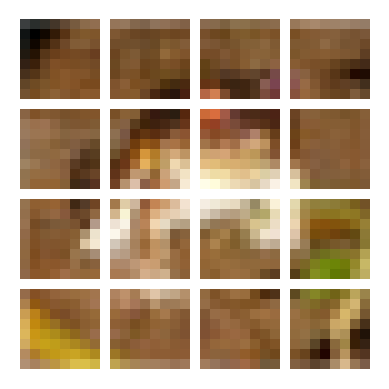

torch.Size([16, 16, 192])

In [68]:
img_batch, labels = next(iter(DataLoader(train_dataset, batch_size=16)))
unfolded = patching(img_batch)
visualize_patches(unfolded[0], 8, nrow=4) # visualize fist sequence from batch
unfolded.shape

### 4. Vision Transformer

W przypadku używania class token-a sieć nie chciała się uczyć, loss nie spadał poniżej 2, a accuracy cały czas wynosiła 10%, prawdopodobnie zrobiłem coś źle jednak nie udało mi się znaleźć przyczyny takich wyników. Ostatecznie na ostatnie warstwy sieci trafiał wektor będący średnią z embeddingów patchy, wtedy wyniki się poprawiły.

In [69]:
class Transformer(nn.Module):

    def __init__(
            self,
            input_embedding_size: int,
            hidden_layer_size: int,
            attention_heads: int,
            dropout_rate: float
        ):

        super().__init__()

        self.layer_norm1= nn.LayerNorm(input_embedding_size)
        self.layer_norm2= nn.LayerNorm(input_embedding_size)

        self.linear1 = nn.Linear(input_embedding_size, hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size, input_embedding_size)

        self.attention = nn.MultiheadAttention(input_embedding_size, attention_heads)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        y = self.layer_norm1(x)
        y, _ = self.attention(y, y, y)
        x = x + y
        y = self.layer_norm2(x)

        y = self.linear1(y)
        y = self.gelu(y)
        y = self.dropout(y)
        y = self.linear2(y)
        y = self.dropout(y)
        x = x + y
        return x

In [70]:
class VIT(nn.Module):

    def __init__(
            self, 
            patch_size: int, 
            original_image_size: int,
            embedding_dim: int,
            output_classes: int,
            hidden_layer_dim: int,
            attention_heads: int,
            dropout_rate: float,
            number_of_transformers: int

        ):

        super().__init__()

        self.patching = Patch(patch_size, original_image_size)
        self.linear = nn.Linear(self.patching.patch_embedding_size, embedding_dim)

        self.pos_encoding = nn.Parameter(torch.randn(1, self.patching.patches_per_example, embedding_dim), requires_grad=True)
        
        self.transformer_layers = nn.Sequential(*[
            Transformer(
                embedding_dim,
                hidden_layer_dim,
                attention_heads,
                dropout_rate
            )
            for _ in range(number_of_transformers)
        ])

        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.linear_decision = nn.Linear(embedding_dim, output_classes)


    def forward(self, x):

        x = self.patching(x)
        x = self.linear(x)

        x = x + self.pos_encoding
        x = self.dropout(x)

        x = self.transformer_layers(x)
        x = x.mean(1)
        final = self.layer_norm(x)
        final = self.linear_decision(final)

        return final

In [71]:
vit = VIT(
    patch_size=8, 
    original_image_size=32, 
    embedding_dim=256, 
    output_classes=10,
    hidden_layer_dim=512,
    attention_heads=8,
    dropout_rate=0.2,
    number_of_transformers=2
)

out = vit(img_batch)
out.shape

torch.Size([16, 10])

In [72]:
sum(p.numel() for p in vit.parameters())

1110794

Dla większej przejrzystości diagram przedstawia computation graph z 2 transformerami.

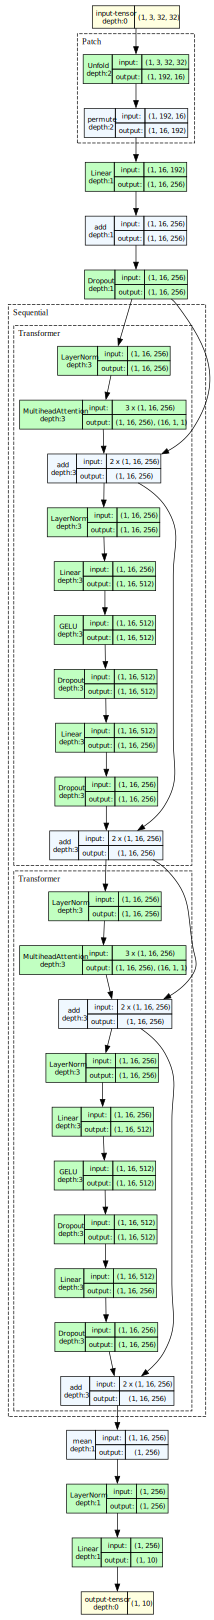

In [73]:
from torchview import draw_graph


model_graph = draw_graph(vit, input_size=(1, 3, 32, 32), expand_nested=True)
model_graph.visual_graph

In [74]:
def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


device = choose_device()
device

'mps'

In [75]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ConstantLR


def compute_test_accuracy(net: nn.Module, data_loader: DataLoader):
    correct_per_class = torch.zeros(10).to(device)
    total_per_class = torch.zeros(10).to(device)

    net = net.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)

            _, predictions = torch.max(outputs, 1)

            correct_labels = labels == predictions
            for i in range(10):
                correct_per_class[i] += (correct_labels & (labels == i)).sum()
                total_per_class[i] += (labels == i).sum()
    
    for i in range(10):
        print(f"{classes[i]}: {(100*correct_per_class[i] / total_per_class[i]):.2f}%")

    print(f"\nTotal accuracy: {(100*correct_per_class.sum() / total_per_class.sum()):.2f}%")

def train_model(
        model: VIT, 
        train_dataset: DataLoader, 
        test_dataset: DataLoader,
        max_epochs: int = 160,
        logging_step: int = 5
    ) -> VIT:

    optimizer = AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = ConstantLR(optimizer, factor=0.1)

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        number_of_batches = 0

        model.train()

        for inputs, labels in train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
            epoch_loss += batch_loss.item()
            number_of_batches += 1
        
        
        train_loss = epoch_loss / number_of_batches
        
        if epoch == 100 or epoch == 150:
            lr_scheduler.step()

        if epoch % logging_step == 0:
            print(f"Epoch {epoch}")
            print(f"Train average loss: {train_loss:.3f}\n")

        if epoch % 10 == 0:
            compute_test_accuracy(vit, test_dataset)

    return model

In [84]:
vit = VIT(
    patch_size=8, 
    original_image_size=32,
    embedding_dim=256, 
    output_classes=10,
    hidden_layer_dim=512,
    attention_heads=8,
    dropout_rate=0.2,
    number_of_transformers=6
).to(device)

train_data_loader = DataLoader(augmented_dataset, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=128)


In [ ]:
vit = train_model(vit, train_data_loader, test_data_loader)

In [96]:
# Wyniki dla zbioru treningowego
compute_test_accuracy(vit, train_data_loader)

plane: 82.64%
car: 91.94%
bird: 77.64%
cat: 79.82%
deer: 79.68%
dog: 68.24%
frog: 88.12%
horse: 84.50%
ship: 93.26%
truck: 89.42%

Total accuracy: 83.53%


In [97]:
# Wyniki dla zbioru testowego
compute_test_accuracy(vit, test_data_loader)

plane: 75.40%
car: 85.30%
bird: 62.10%
cat: 60.20%
deer: 68.00%
dog: 56.60%
frog: 81.00%
horse: 76.80%
ship: 84.80%
truck: 81.80%

Total accuracy: 73.20%


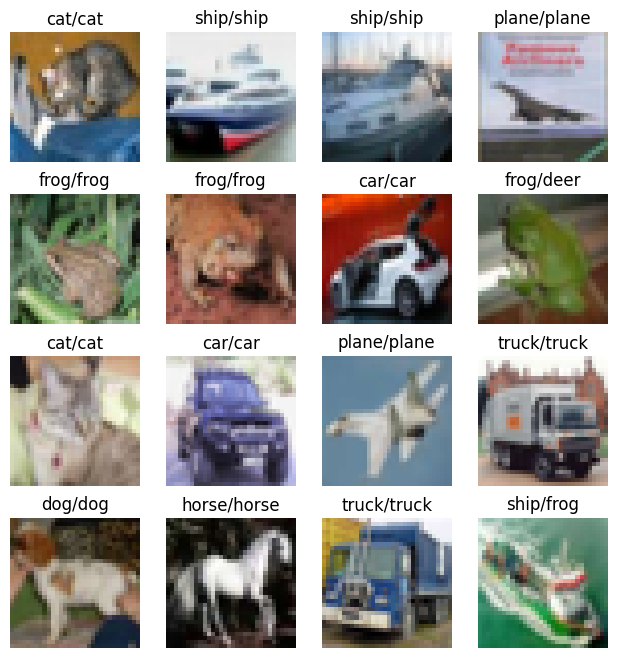

In [98]:
from matplotlib import gridspec

def plot_image_grid(
        image_batch: torch.tensor, 
        batch_classes: torch.tensor, 
        pred_classes: Optional[torch.tensor],
        img_per_row: int = 4,
    ):
    no_of_rows = len(batch_classes) // img_per_row
    plt.figure(figsize = (no_of_rows * 2, img_per_row * 2))
    gs = gridspec.GridSpec(no_of_rows, img_per_row)
    gs.update(wspace=0.025, hspace=0.25)
    
    for i in range(no_of_rows):
        for j in range(img_per_row):
            idx = i*no_of_rows + j
            ax = plt.subplot(gs[idx])
            img = image_batch[idx]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            
            if pred_classes is not None:
                ax.set_title(f"{classes[batch_classes[idx].item()]}/{classes[pred_classes[idx].item()]}")
            else:
                ax.set_title(classes[batch_classes[idx]])
                
            ax.axis('off')
            ax.imshow(img.permute(1, 2, 0))
            
    plt.show()

example_batch, real_labels = next(iter(test_data_loader))
example_batch, real_labels = example_batch[:16], real_labels[:16]

vit.to("cpu").eval()
with torch.no_grad():
    predictions = torch.argmax(vit(example_batch), axis=1)

plot_image_grid(unnormalize_batch(example_batch), real_labels, predictions)